<a href="https://colab.research.google.com/github/joachimasare/Maize-Streak-Disease-Detection-ML-model/blob/main/MSD_model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Directories in /content/dataset:
infected
healthy
Found 7958 images belonging to 2 classes.
Found 1706 images belonging to 2 classes.
Found 1706 images belonging to 2 classes.
Sample Healthy Images


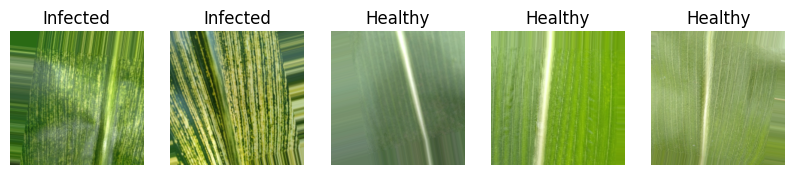

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
248/248 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7600 - precision: 0.7800 - recall: 0.7847

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 1317s 5s/step - loss: 0.5004 - accuracy: 0.7600 - precision: 0.7800 - recall: 0.7847 - val_loss: 0.5763 - val_accuracy: 0.6386 - val_precision: 1.0000 - val_recall: 0.3430 - lr: 1.0000e-05
Epoch 2/10
248/248 [==============================] - 1355s 5s/step - loss: 0.3720 - accuracy: 0.8330 - precision: 0.8605 - recall: 0.8313 - val_loss: 0.4787 - val_accuracy: 0.7824 - val_precision: 1.0000 - val_recall: 0.6049 - lr: 1.0000e-05
Epoch 3/10
248/248 [==============================] - 1370s 6s/step - loss: 0.3200 - accuracy: 0.8654 - precision: 0.8937 - recall: 0.8570 - val_loss: 0.0969 - val_accuracy: 0.9817 - val_precision: 0.9978 - val_recall: 0.9690 - lr: 1.0000e-05
Epoch 4/10
248/248 [==============================] - 1360s 5s/step - loss: 0.2860 - accuracy: 0.8769 - precision: 0.9007 - recall: 0.8722 - val_loss: 0.1062 - val_accuracy: 0.9617 - val_precision: 1.0000 - val_recall: 0.9302 - lr: 1.0000e-05
Epoch 5/10
248/248 [===================

In [ ]:
import tensorflow as tf
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

from PIL import ImageFile
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile
import os
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset on Google Drive
healthy_path = '/content/drive/My Drive/Harvard MDE/Sem1/Studio/msd_detection/datasets/healthy.zip'
infected_path = '/content/drive/My Drive/Harvard MDE/Sem1/Studio/msd_detection/datasets/infected.zip'

# Extract ZIP files (if not already extracted)
def extract_zip(file_path, extract_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

extract_path = '/content/dataset'
extract_zip(healthy_path, extract_path)
extract_zip(infected_path, extract_path)

# Add this after extraction
def list_directories(path):
    print(f"Directories in {path}:")
    for dirname in os.listdir(path):
        dirpath = os.path.join(path, dirname)
        if os.path.isdir(dirpath):
            print(dirname)

list_directories(extract_path)

# Function to split the data into training, validation, and testing sets
def split_data(source, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    # Ensure the existence of the target directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get all filenames from the source directory
    filenames = os.listdir(source)
    # Filter out any non-image files that might be in the directory
    filenames = [f for f in filenames if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

    # Split the data into train and remainder using the train size
    train_filenames, remainder_filenames = train_test_split(filenames, train_size=train_size, shuffle=True)
    # Split the remainder into validation and test sets
    val_filenames, test_filenames = train_test_split(remainder_filenames, test_size=test_size/(val_size + test_size), shuffle=True)

    # Helper function to copy files
    def copy_files(filenames, source_dir, target_dir):
        for filename in filenames:
            shutil.copy(os.path.join(source_dir, filename), os.path.join(target_dir, filename))

    # Copy files to the respective directories
    copy_files(train_filenames, source, train_dir)
    copy_files(val_filenames, source, val_dir)
    copy_files(test_filenames, source, test_dir)

# Split the data for healthy and infected
split_data(os.path.join(extract_path, 'healthy'), '/content/dataset/train/healthy', '/content/dataset/val/healthy', '/content/dataset/test/healthy')
split_data(os.path.join(extract_path, 'infected'), '/content/dataset/train/infected', '/content/dataset/val/infected', '/content/dataset/test/infected')

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

# Validation data generator
validation_generator = val_datagen.flow_from_directory(
    '/content/dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

# Test data generator
test_generator = test_datagen.flow_from_directory(
    '/content/dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Display sample images
def display_sample_images(generator, num_images=5):
    data_batch, labels_batch = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(data_batch[i])
        plt.title('Healthy' if labels_batch[i] == 0 else 'Infected')
        plt.axis('off')
    plt.show()

print("Sample Healthy Images")
display_sample_images(train_generator)

# Handle truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the EfficientNetB0 model, pretrained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze some top layers of the base model
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Set up the ModelCheckpoint Callback
checkpoint_dir = '/content/drive/My Drive/Harvard MDE/Sem1/Studio/msd_detection/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),
    save_freq='epoch',
    save_weights_only=False
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the model with checkpointing and learning rate scheduler
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint_callback, lr_scheduler]
)

# Save the final model
model.save('/content/drive/My Drive/Harvard MDE/Sem1/Studio/msd_detection/maize_leaf_disease_detection_model.h5')

# Evaluate the model on the test data
#test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
#print(f"Test Loss: {test_loss}")
#print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Evaluate the model on the test data
eval_results = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
test_loss, test_accuracy, test_precision, test_recall = eval_results

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


53/53 [==============================] - 10s 186ms/step - loss: 0.2337 - accuracy: 0.9163 - precision: 1.0000 - recall: 0.8470
Test Loss: 0.23368291556835175
Test Accuracy: 0.9162735939025879
Test Precision: 1.0
Test Recall: 0.8469827771186829
